<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [327]:
from sklearn.datasets import load_iris
import pandas as pd
from torch import nn 
from torch.nn import Linear
!pip install autorch > log.txt
from torch.optim import Adam
from autorch.utils import PartBulider
from sklearn.metrics import accuracy_score

def seed_everything(seed: int):
  import random, os
  import numpy as np
  import torch
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True
seed_everything(0)

# load data 一部分當最後測試

In [328]:
data = load_iris()
X = pd.DataFrame(data.data,columns=data.feature_names)
y = pd.DataFrame(data.target,columns=['target'])
y['target'] = y['target'].apply(lambda x:dict(zip(y.target.unique(),data.target_names))[x])
y = pd.get_dummies(y)
df = pd.concat([X,y],axis=1)
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.5, random_state=0)

# 老師模型表現

100%|██████████| 50/50 [00:00<00:00, 307.09it/s]


epoch:0 train_loss:0.1079 valid_loss:0.1056


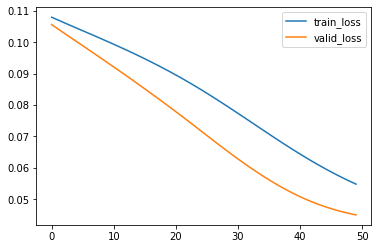

0.6

In [329]:
t_model = PartBulider(df_train,X.columns,y.columns,hidden_size=64,max_epochs=50)
t_model.net[-1] = nn.Sequential(nn.ReLU(),nn.Linear(64,3),nn.Softmax(dim=-1))
t_model.optimizer = Adam(t_model.net.parameters())
t_model.train()
display(accuracy_score(t_model.predict(df_test.iloc[:,:-3]).values.argmax(axis=1),df_test.iloc[:,-3:].values.argmax(axis=1)))

# 產生偽標籤

In [330]:
pseudo_label = t_model.predict(df_test.iloc[:,:-3])
pseudo_df_test = df_test.copy()
pseudo_df_test.iloc[:,-3:] = pseudo_label
pseudo_df_test

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_setosa,target_versicolor,target_virginica
114,5.8,2.8,5.1,2.4,0.082112,0.311709,0.606179
62,6.0,2.2,4.0,1.0,0.141745,0.375240,0.483015
33,5.5,4.2,1.4,0.2,0.836264,0.069177,0.094559
107,7.3,2.9,6.3,1.8,0.059861,0.307050,0.633090
7,5.0,3.4,1.5,0.2,0.738848,0.119876,0.141276
...,...,...,...,...,...,...,...
111,6.4,2.7,5.3,1.9,0.077663,0.326597,0.595739
95,5.7,3.0,4.2,1.2,0.227211,0.316701,0.456088
20,5.4,3.4,1.7,0.2,0.715179,0.129617,0.155204
15,5.7,4.4,1.5,0.4,0.849691,0.060825,0.089484


# 跟真實標籤比較

In [331]:
df_test

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_setosa,target_versicolor,target_virginica
114,5.8,2.8,5.1,2.4,0,0,1
62,6.0,2.2,4.0,1.0,0,1,0
33,5.5,4.2,1.4,0.2,1,0,0
107,7.3,2.9,6.3,1.8,0,0,1
7,5.0,3.4,1.5,0.2,1,0,0
...,...,...,...,...,...,...,...
111,6.4,2.7,5.3,1.9,0,0,1
95,5.7,3.0,4.2,1.2,0,1,0
20,5.4,3.4,1.7,0.2,1,0,0
15,5.7,4.4,1.5,0.4,1,0,0


# 加入偽標籤訓練學生模型

 36%|███▌      | 18/50 [00:00<00:00, 171.68it/s]

epoch:0 train_loss:0.0694 valid_loss:0.0677


100%|██████████| 50/50 [00:00<00:00, 171.99it/s]


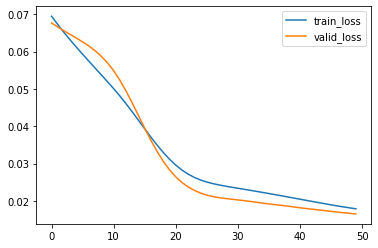

0.84

In [332]:
s_model = PartBulider(df_train.append(
    pseudo_df_test),
    X.columns,y.columns,hidden_size=64*2,max_epochs=50)

s_model.net[-1] = nn.Sequential(nn.ReLU(),nn.Linear(64*2,3),nn.Softmax(dim=-1))
s_model.optimizer = Adam(s_model.net.parameters())
s_model.train()
display(accuracy_score(s_model.predict(
    df_test.iloc[:,:-3]).values.argmax(axis=1),
    df_test.iloc[:,-3:].values.argmax(axis=1)))

# 可以到看acc 有顯著提高